In [1]:
import utils
import pandas
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt

from datetime import datetime, date

from scipy.misc import imresize
import features


In [2]:
import json
import pandas

In [3]:
from sklearn import linear_model, datasets
from sklearn.metrics import mean_squared_error as MSE, r2_score as R2S
from sklearn.isotonic import check_increasing

from scipy.stats import pearsonr

List of users

    anamaria16          eightturncrepeny  iceandvice             minastaartenwereld  taiyakinyc
    cake.and.sweets.17  ezgipolat         instagram-scraper.log  muradosmann         way_cake
    carlifestyle        garrylarduinat    jacquesgenin           omjsk               zachking
    carolina_nusadua    gunopark          jamesjeanart           pierreherme
    cedricgrolet        helloemilie       joannagaines           pollykosheleva
    danbilzerian        hungrygrls        lolly_cakery           somepaintings
    dinarakasko         iamdessertlover   menwithstreetstyle     stuffbeneats

List of tags

    posts3_cake_1505409284.json        posts_icecream_1505846777.json
    images_cake_1505409284.npy         posts3_cakes_1505469028.json     posts_latte_1505845000.json
    images_cakes_1505441948.npy        posts3_icecream_1505846777.json

In [4]:
userSpecific = False

if userSpecific:
    posts,images = utils.dataFromScraper('jamesjeanart')
    dfp = pandas.DataFrame(posts)
    bytag = False
    
else:
    bytag = True
    posts, images = utils.getData('posts_cake_1505409284.json',updated=True,rawimages=True)
    with open('data/users_cake_1505409284.json','r') as infile:
            users = json.load(infile)
    dfu = pandas.DataFrame(users)
    dfp = pandas.DataFrame(posts)

In [5]:
# Extract image features

nbins = 20
nposts0 = len(posts)
satH = np.zeros([nposts0,nbins])
conH = np.zeros([nposts0,nbins])
sat = np.zeros(nposts0)
contrast = np.zeros(nposts0)

dims = 5
comp = np.zeros([nposts0,dims**2])

kernelCos,kernelSin,kernelCor1,kernelCor2,kernelCor3,kernelCor4 = features.compKernels(dims)
kCos = np.zeros(nposts0)
kSin = np.zeros(nposts0)
kCor1 = np.zeros(nposts0)
kCor2 = np.zeros(nposts0)
kCor3 = np.zeros(nposts0)
kCor4 = np.zeros(nposts0)

for i in range(len(posts)):
    satH[i],_ = np.histogram(features.colorfulness(images[i]), bins=nbins)
    satH[i] = satH[i]/np.sqrt(np.sum(satH[i]**2))
    sat[i] = np.mean(features.colorfulness(images[i]))
    intensity = np.mean(images[i],2)
    conH[i],_ = np.histogram(intensity, bins=nbins)
    conH[i] = conH[i]/np.sqrt(np.sum(conH[i]**2))
    contrast[i] = features.contrast(images[i])
    comp[i] = imresize(intensity,[dims,dims]).reshape([dims**2])

    temp = imresize(intensity,[dims,dims])
    kCos[i] = np.mean(temp*kernelCos)
    kSin[i] = np.mean(temp*kernelSin)
    kCor1[i] = np.mean(temp*kernelCor1)
    kCor2[i] = np.mean(temp*kernelCor2)
    kCor3[i] = np.mean(temp*kernelCor3)
    kCor4[i] = np.mean(temp*kernelCor4)
    

# Extract features

likes = dfp['likes'].apply(lambda x: float(features.convertString(x))).values
ntags = dfp[u'caption'].apply(lambda x: float( len(x.split(' #')) ) ).values - 1
#mult = dfp[u'ismultiple'].values

if userSpecific:
    hour = dfp[u'createdtime'].apply(lambda x: features.extractTimeData(x)[1]).values
    weekday = dfp[u'createdtime'].apply(lambda x: features.extractTimeData(x)[0]).values

if bytag:
    followers = dfu['followers'].apply(lambda x: float( features.convertString(x) )).values
    following = dfu['following'].apply(lambda x: features.convertString(x)).values
    user_nposts = dfu[u'nposts'].apply(lambda x: features.getnposts(x)).values
    hour = dfp[u'date'].apply(lambda x: features.extractTimeData(x)[1]).values
    weekday = dfp[u'date'].apply(lambda x: features.extractTimeData(x)[0]).values
    meanlikes = dfu[u'meanlikes'].values
    mult = dfp[u'ismultiple'].values

a = np.array([1, 0, 3])
weekdayvec = np.zeros([nposts0,8])
hourvec = np.zeros([nposts0,26])
weekdayvec[np.arange(nposts0), weekday] = 1
hourvec[np.arange(nposts0), hour] = 1


In [16]:
counter = 0
meanlikes2 = meanlikes
for i in range(nposts0):
    if np.isnan(meanlikes[i]):
        counter+=1
        meanlikes2[i] = 0.
print counter
print np.mean(meanlikes2)

0
6.11146070867


In [17]:
# # Normalize data

# minsat = np.min(sat)
# maxsat = np.max(sat)
# mincon = np.min(contrast)
# maxcon = np.max(contrast)
# minlike = min(likes)
# maxlike = max(likes)
# mintags = min(ntags)
# maxtags = max(ntags)

# normSinA = np.abs(kSin)/np.max(np.abs(kSin))

# normsat = (sat - minsat)/(maxsat-minsat)
# normcontrast = (contrast - mincon)/(maxcon-mincon)
# normlikes = (likes - minlike)/(maxlike - minlike)
# normcomp = comp/255.
# normNtags = (ntags - np.mean(ntags))/(maxtags - mintags)
# normCos = (kCos - np.mean(kCos))/(np.max(kCos) - np.min(kCos))
# normSin = (kSin - np.mean(kSin))/(np.max(kSin) - np.min(kSin))



    
# Vectorize data

if bytag:
    
    nfeatures = 1+2+4+1+1+1+7+24+4+1
    data = np.zeros([nposts0,nfeatures])
    data[:,0] = kCos
    data[:,1] = kSin
    data[:,2] = np.abs(kSin)
    data[:,3] = kCor1
    data[:,4] = kCor2
    data[:,5] = kCor3
    data[:,6] = kCor4
    data[:,7] = sat
    data[:,8] = contrast
    data[:,9] = ntags
    data[:,10:17] = weekdayvec[:,0:7]
    data[:,17:41] = hourvec[:,0:24]
    data[:,41] = mult
    data[:,42] = followers
    data[:,43] = following
    data[:,44] = user_nposts
    data[:,45] = meanlikes2

else:
    
    nfeatures = 1+2+4+1+1+1+7+24+4+1
    data = np.zeros([nposts0,nfeatures])
    data[:,0] = kCos
    data[:,1] = kSin
    data[:,2] = np.abs(kSin)
    data[:,3] = kCor1
    data[:,4] = kCor2
    data[:,5] = kCor3
    data[:,6] = kCor4
    data[:,7] = sat
    data[:,8] = contrast
    data[:,9] = ntags
    data[:,10:17] = weekdayvec[:,0:7]
    data[:,17:] = hourvec[:,0:24]

# if bytag:

#     nfeatures = 1+2+4+1+1+1+7+24+4+1
#     data = np.zeros([nposts0,nfeatures])
#     data[:,0] = normCos
#     data[:,1] = normSin
#     data[:,2] = normSinA
#     data[:,3] = kCor1/np.max(kCor1)
#     data[:,4] = kCor2/np.max(kCor2)
#     data[:,5] = kCor3/np.max(kCor3)
#     data[:,6] = kCor4/np.max(kCor4)
#     data[:,7] = normsat
#     data[:,8] = normcontrast
#     data[:,9] = normNtags
#     data[:,10:17] = weekdayvec[:,0:7]
#     data[:,17:41] = hourvec[:,0:24]
#     data[:,41] = mult
#     data[:,42] = followers/np.mean(followers)*.2
#     data[:,43] = following/np.mean(following)*.2
#     data[:,44] = user_nposts/np.mean(user_nposts)*.3
#     data[:,45] = meanlikes2/np.mean(meanlikes2)*.4

# else:

#     nfeatures = 1+2+4+1+1+1+7+24
#     data = np.zeros([nposts0,nfeatures])
#     data[:,0] = normCos
#     data[:,1] = normSin
#     data[:,2] = normSinA
#     data[:,3] = kCor1/np.max(kCor1)
#     data[:,4] = kCor2/np.max(kCor2)
#     data[:,5] = kCor3/np.max(kCor3)
#     data[:,6] = kCor4/np.max(kCor4)
#     data[:,7] = normsat
#     data[:,8] = normcontrast
#     data[:,9] = normNtags
#     data[:,10:17] = weekdayvec[:,0:7]
#     data[:,17:] = hourvec[:,0:24]





# Set normalize bounds

minvals = np.zeros([nfeatures])
maxvals = np.ones([nfeatures])
centervals = np.zeros([nfeatures])

min_y = min(likes)
max_y = max(likes)
center_y = min(likes)

if bytag:
    
    minvals[0] = np.max(kCos)
    minvals[1] = np.max(kSin)
    minvals[2] = np.max(np.abs(kSin))
    minvals[3] = np.max(kCor1)
    minvals[4] = np.max(kCor2)
    minvals[5] = np.max(kCor3)
    minvals[6] = np.max(kCor4)
    minvals[7] = np.max(sat)
    minvals[8] = np.max(contrast)
    minvals[9] = np.max(ntags)
    #minvals[10:17]
    #minvals[17:41]
    #minvals[41]
    #minvals[42] = 0
    #minvals[43] = 0
    minvals[44] = np.max(user_nposts)
    minvals[45] = np.max(meanlikes2)

    maxvals[0] = np.min(kCos)
    maxvals[1] = np.min(kSin)
    #maxvals[2] = 0.
    #maxvals[3] = 0
    #maxvals[4] = 0
    #maxvals[5] = 0
    #maxvals[6] = 0
    maxvals[7] = np.min(sat)
    maxvals[8] = np.min(contrast)
    maxvals[9] = np.min(ntags)
    #maxvals[10:17]
    #maxvals[17:41]
    #maxvals[41]
    maxvals[42] = followers[ followers.argsort()[int(nposts0*.85)] ]
    maxvals[43] = following[ following.argsort()[int(nposts0*.85)] ]
    #maxvals[44] = np.min(user_nposts)
    #maxvals[45] = np.max(meanlikes2)

    centervals[0] = np.mean(kCos)
    centervals[1] = np.mean(kSin)
    #centervals[2] = 0.
    #centervals[3] = 0
    #centervals[4] = 0
    #centervals[5] = 0
    #centervals[6] = 0
    centervals[7] = np.min(sat)
    centervals[8] = np.min(contrast)
    centervals[9] = np.mean(ntags)
    #centervals[10:17]
    #centervals[17:41]
    #centervals[41]
    #centervals[42] = 0
    #centervals[43] = 0
    #centervals[44] = np.min(user_nposts)
    #centervals[45] = np.max(meanlikes2)

else:
    
    minvals[0] = np.max(kCos)
    minvals[1] = np.max(kSin)
    minvals[2] = np.max(np.abs(kSin))
    minvals[3] = np.max(kCor1)
    minvals[4] = np.max(kCor2)
    minvals[5] = np.max(kCor3)
    minvals[6] = np.max(kCor4)
    minvals[7] = np.max(sat)
    minvals[8] = np.max(contrast)
    minvals[9] = np.max(ntags)
    #minvals[10:17]
    #minvals[17:]

    maxvals[0] = np.min(kCos)
    maxvals[1] = np.min(kSin)
    #maxvals[2] = 0.
    #maxvals[3] = 0
    #maxvals[4] = 0
    #maxvals[5] = 0
    #maxvals[6] = 0
    maxvals[7] = np.min(sat)
    maxvals[8] = np.min(contrast)
    maxvals[9] = np.min(ntags)
    #maxvals[10:17]
    #maxvals[17:]

    centervals[0] = np.mean(kCos)
    centervals[1] = np.mean(kSin)
    #centervals[2] = 0.
    #centervals[3] = 0
    #centervals[4] = 0
    #centervals[5] = 0
    #centervals[6] = 0
    centervals[7] = np.min(sat)
    centervals[8] = np.min(contrast)
    centervals[9] = np.mean(ntags)
    #centervals[10:17]
    #centervals[17:]

    
    


# Normalize data

for i in range(nfeatures):
    data[:,i] = (data[:,i] - centervals[i]) / (maxvals[i] - minvals[i])
    
y_orig = (likes - center_y) / (max_y - min_y)

Without feature 00:
MSE: 0.000001
R2S: 0.733788
Without feature 01:
MSE: 0.000001
R2S: 0.731663
Without feature 02:
MSE: 0.000001
R2S: 0.735323
Without feature 03:
MSE: 0.000001
R2S: 0.728861
Without feature 04:
MSE: 0.000001
R2S: 0.733909
Without feature 05:
MSE: 0.000001
R2S: 0.729288
Without feature 06:
MSE: 0.000001
R2S: 0.734795
Without feature 07:
MSE: 0.000001
R2S: 0.734318
Without feature 08:
MSE: 0.000001
R2S: 0.733597
Without feature 09:
MSE: 0.000001
R2S: 0.722991
Without feature 10:
MSE: 0.000001
R2S: 0.733650
Without feature 11:
MSE: 0.000001
R2S: 0.733650
Without feature 12:
MSE: 0.000001
R2S: 0.733650
Without feature 13:
MSE: 0.000001
R2S: 0.733650
Without feature 14:
MSE: 0.000001
R2S: 0.733650
Without feature 15:
MSE: 0.000001
R2S: 0.733650
Without feature 16:
MSE: 0.000001
R2S: 0.733650
Without feature 17:
MSE: 0.000001
R2S: 0.733650
Without feature 18:
MSE: 0.000001
R2S: 0.733650
Without feature 19:
MSE: 0.000001
R2S: 0.733650
Without feature 20:
MSE: 0.000001
R2S: 0

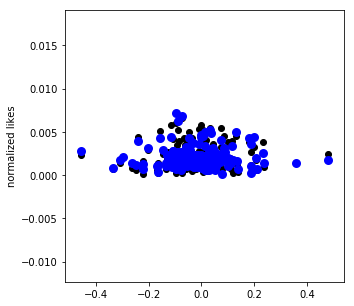

(47, 47) (47, 47)


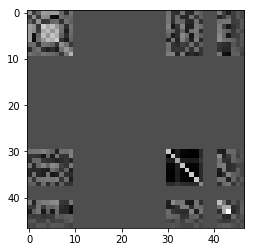

[-0.01584018 -0.02729373  0.04000678  0.04015601 -0.01754817  0.04488125
  0.0367996   0.02817509 -0.02702662 -0.06158976  0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.02138721  0.03435872  0.00759119
 -0.03251146 -0.03714841 -0.02970203  0.04450209 -0.03256806  0.          0.
  0.          0.04161411  0.07258738  0.07196233  0.01388786 -0.02623837
  0.02094634]


In [55]:
# Prune data
    
keep = (likes < 10000) & (likes > 1) #& (ntags < 18)
keep = dfp.apply(features.not_in_list,args=[u'fashion',0],axis=1).values & keep

if bytag:
    likeOrder = likes.argsort()
    keep = np.zeros(nposts0, dtype=bool)
    keep[ likeOrder[int(nposts0*.05):int(nposts0*.90)].tolist() ] = True
    followOrder = followers.argsort()
    keep[ followOrder[int(nposts0*.85):].tolist() ] = False
    
    meanOrder = meanlikes2.argsort()
    keep[ meanOrder[:int(nposts0*.05)].tolist() ] = False
    keep[ meanOrder[int(nposts0*.95):].tolist() ] = False
    keep = keep & (meanlikes2 > 0.00001)

elif True:
    likeOrder = likes.argsort()
    keep = np.zeros(nposts0, dtype=bool)
    keep[ likeOrder[int(nposts0*.05):int(nposts0*.90)].tolist() ] = True

goodData = data[keep,:]
y = y_orig[keep]


# Split into test and training sets

nposts = len(goodData)
test = ((np.arange(nposts) % 10) == 0) | ((np.arange(nposts) % 10) == 3)
crossval = ((np.arange(nposts) % 10) == 1) | ((np.arange(nposts) % 10) == 5)
train = np.logical_not(test) & np.logical_not(crossval)
ntrain = len(np.where(train)[0])
ncross = len(np.where(crossval)[0])


# Run regression with each feature missing
# so that we can see each feature's effect on the R^2 score

MSE_results = np.zeros(nfeatures)
R2S_results = np.zeros(nfeatures)

for i in range(nfeatures):

    featureList = [True]*nfeatures
    featureList[i] = False
    
    temp = goodData[:,featureList]

    data_train = temp[train,:]
    data_cross = temp[crossval,:]
    data_test = temp[test,:]

    y_train = y[train]
    y_cross = y[crossval]
    y_test = y[test]

    regr = linear_model.LinearRegression()
    regr.fit(data_train, y_train)

    y_pred = regr.predict(data_cross)

    MSE_results[i] = MSE(y_cross, y_pred)
    R2S_results[i] = R2S(y_cross, y_pred)
    print 'Without feature %02i:'%i
    print 'MSE: %8f'%MSE_results[i]
    print 'R2S: %8f'%R2S_results[i]
    

# Run regression on all features

data_train = goodData[train,:]
data_cross = goodData[crossval,:]
data_test = goodData[test,:]

y_train = y[train]
y_cross = y[crossval]
y_test = y[test]

regr = linear_model.LinearRegression()
regr.fit(data_train, y_train)

y_pred = regr.predict(data_cross)

MSEall = MSE(y_cross, y_pred)
R2Sall = R2S(y_cross, y_pred)

print ''
print 'With all features:'
print 'MSE: %8f'%MSEall
print 'R2S: %8f'%R2Sall


print 'Features by order of importance: '
print R2S_results.argsort()
    
if True:

    fig = plt.figure(figsize=[5,5])
    feat = 0
    plt.scatter(data_cross[:,feat], y_cross,  color='black')
    plt.scatter(data_cross[:,feat], y_pred, color='blue', linewidth=3)
    #plt.xlabel('normalized contrast')
    plt.ylabel('normalized likes')
    plt.show()

    cov = np.cov(np.append(data_train,y_train.reshape([ntrain,1]),axis=1).transpose())
    #rescale = (lambda x: np.sqrt(x) if (x >= 0) else -np.sqrt(-x))
    covplot = cov
    
    indices = (cov >= 0)
    print indices.shape, cov.shape
    covplot[indices] = np.power(cov[indices],.3)
    meanpos = np.mean(covplot[indices])
    
    indices = (cov < 0)
    covplot[indices] = -np.power(-cov[indices],.3)
    meanneg = np.mean(covplot[indices])
    
    if False:
        covplot = np.append(covplot[:,:38],covplot[:,41:],axis=1)
        covplot = np.append(covplot[:,:9],covplot[:,30:],axis=1)
        covplot = np.append(covplot[:38,:],covplot[41:,:],axis=0)
        covplot = np.append(covplot[:9,:],covplot[30:,:],axis=0)
        limit = np.max( np.array([-meanneg,meanpos]) )
        plt.imshow(covplot,cmap='bwr',vmin=-limit,vmax=limit)
    else:
        plt.imshow(covplot,cmap='gray')
    plt.show()
    print cov[-1,:] #, data_test[1,:]


In [56]:
# Run regression on test set with most informative features

feature_helps = R2Sall > R2S_results + .0001
feature_helps_alot = R2Sall > R2S_results + .02
if np.sum(feature_helps_alot) > nfeatures*.5:
    featureList = feature_helps_alot
elif np.sum(feature_helps) > np.ceil(nfeatures*.5):
    featureList = np.median(R2S_results) > R2S_results
elif np.sum(feature_helps) >= 1:
    featureList = feature_helps
else:
    order = R2S_results.argsort()
    featureList = np.arange(nfeatures) == order[0]
print featureList, np.sum(feature_helps_alot) , np.sum(feature_helps)


# Run regression

temp = goodData[:,featureList]

data_train = temp[train,:]
data_cross = temp[crossval,:]
data_test = temp[test,:]

y_train = y[train]
y_cross = y[crossval]
y_test = y[test]

regr = linear_model.LinearRegression()
regr.fit(data_train, y_train)
y_pred = regr.predict(data_cross)
print ''
print 'Cross Validation with best features:'
print 'MSE: %8f'%MSE(y_cross, y_pred)
print 'R2S: %8f'%R2S(y_cross, y_pred)
print 'Spearman: %8f'%pearsonr(y_cross,y_pred)[0]

regr = linear_model.LinearRegression()
regr.fit(data_train, y_train)
y_pred = regr.predict(data_test)
print ''
print 'Test set with best features:'
print 'MSE: %8f'%MSE(y_test, y_pred)
print 'R2S: %8f'%R2S(y_test, y_pred)
print 'Spearman: %8f'%pearsonr(y_test,y_pred)[0]

ntest = y_test.shape[0]
y_pred = regr.predict(data_test)
yorder = y_pred.argsort()
mean_y = np.mean(y_test)
mean_yp = np.mean(y_test[yorder[int(ntest*.7):]])
#print mean_y, mean_yp
mean_y0 = mean_y*(max_y-min_y) + min_y
mean_yp0 = mean_yp*(max_y-min_y) + min_y
print ''
print 'Average # likes in test set: %.3f   Average # likes in suggested posts: %.3f'%(mean_y0, mean_yp0)
print 'Average increase in likes: %.3f   Total # samples: %d'%(mean_yp0/mean_y0 - 1.,ntest)


# Run regression

imageFeatures = np.ones(featureList.shape,dtype=bool)
imageFeatures[-5:] = False
temp = goodData[:,(featureList & imageFeatures)]

data_train = temp[train,:]
data_cross = temp[crossval,:]
data_test = temp[test,:]

y_train = y[train]
y_cross = y[crossval]
y_test = y[test]

regr = linear_model.LinearRegression()
regr.fit(data_train, y_train)
y_pred = regr.predict(data_cross)
print ''
print 'Cross Validation with best features without user data:'
print 'MSE: %8f'%MSE(y_cross, y_pred)
print 'R2S: %8f'%R2S(y_cross, y_pred)
print 'Spearman: %8f'%pearsonr(y_cross,y_pred)[0]

regr = linear_model.LinearRegression()
regr.fit(data_train, y_train)
y_pred = regr.predict(data_test)
print ''
print 'Test set with best features without user data:'
print 'MSE: %8f'%MSE(y_test, y_pred)
print 'R2S: %8f'%R2S(y_test, y_pred)
print 'Spearman: %8f'%pearsonr(y_test,y_pred)[0]

ntest = y_test.shape[0]
y_pred = regr.predict(data_test)
yorder = y_pred.argsort()
mean_y = np.mean(y_test)
mean_yp = np.mean(y_test[yorder[int(ntest*.7):]])
#print mean_y, mean_yp
mean_y0 = mean_y*(max_y-min_y) + min_y
mean_yp0 = mean_yp*(max_y-min_y) + min_y
print ''
print 'Average # likes in test set: %.3f   Average # likes in suggested posts: %.3f'%(mean_y0, mean_yp0)
print 'Average increase in likes: %.3f   Total # samples: %d'%(mean_yp0/mean_y0 - 1.,ntest)


# Run with just metadata... do images help?

temp = goodData[:,(featureList & np.logical_not(imageFeatures))]

data_train = temp[train,:]
data_cross = temp[crossval,:]
data_test = temp[test,:]

y_train = y[train]
y_cross = y[crossval]
y_test = y[test]

regr = linear_model.LinearRegression()
regr.fit(data_train, y_train)
y_pred = regr.predict(data_cross)
print ''
print 'Cross Validation with just user data:'
print 'MSE: %8f'%MSE(y_cross, y_pred)
print 'R2S: %8f'%R2S(y_cross, y_pred)
print 'Spearman: %8f'%pearsonr(y_cross,y_pred)[0]

regr = linear_model.LinearRegression()
regr.fit(data_train, y_train)
y_pred = regr.predict(data_test)
print ''
print 'Test set with just data:'
print 'MSE: %8f'%MSE(y_test, y_pred)
print 'R2S: %8f'%R2S(y_test, y_pred)
print 'Spearman: %8f'%pearsonr(y_test,y_pred)[0]

ntest = y_test.shape[0]
y_pred = regr.predict(data_test)
yorder = y_pred.argsort()
mean_y = np.mean(y_test)
mean_yp = np.mean(y_test[yorder[int(ntest*.7):]])
#print mean_y, mean_yp
mean_y0 = mean_y*(max_y-min_y) + min_y
mean_yp0 = mean_yp*(max_y-min_y) + min_y
print ''
print 'Average # likes in test set: %.3f   Average # likes in suggested posts: %.3f'%(mean_y0, mean_yp0)
print 'Average increase in likes: %.3f   Total # samples: %d'%(mean_yp0/mean_y0 - 1.,ntest)

[False  True False  True False  True False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True  True] 1 6

Cross Validation with best features:
MSE: 0.000000
R2S: 0.758907
Spearman: 0.871738

Test set with best features:
MSE: 0.000000
R2S: 0.828566
Spearman: 0.919591

Average # likes in test set: 0.002   Average # likes in suggested posts: 0.004
Average increase in likes: 0.788   Total # samples: 162

Cross Validation with best features without user data:
MSE: 0.000002
R2S: 0.037216
Spearman: 0.229664

Test set with best features without user data:
MSE: 0.000003
R2S: 0.052691
Spearman: 0.232072

Average # likes in test set: 0.002   Average # likes in suggested posts: 0.003
Average increase in likes: 0.267   Total # samples: 162

Cross Validation with just user data:
MSE: 0.000001
R2S: 0.743889
Spearman: 0.8629

In [10]:
ntest = y_test.shape[0]
y_pred = regr.predict(data_test)
yorder = y_pred.argsort()
mean_y = np.mean(y_test)
mean_yp = np.mean(y_test[yorder[int(ntest*.7):]])
#print mean_y, mean_yp
mean_y0 = mean_y*(max_y-min_y) + min_y
mean_yp0 = mean_yp*(max_y-min_y) + min_y
print 'Average # likes in test set: %.3f   Average # likes in suggested posts: %.3f'%(mean_y0, mean_yp0)
print 'Average increase in likes: %.3f   Total # samples: %d'%(mean_yp0/mean_y0 - 1.,ntest)

Average # likes in test set: 34.920   Average # likes in suggested posts: 62.041
Average increase in likes: 0.777   Total # samples: 162


In [11]:
import pickle

imageFeatures = np.ones(featureList.shape,dtype=bool)
imageFeatures[8:] = False
temp = goodData[:,(featureList & imageFeatures)]

data_train = temp[train,:]
data_cross = temp[crossval,:]
data_test = temp[test,:]

y_train = y[train]
y_cross = y[crossval]
y_test = y[test]

regr = linear_model.LinearRegression()
regr.fit(data_train, y_train)

filename = 'models/LR_model_cake.sav'
pickle.dump([regr,(featureList&imageFeatures), min_y,max_y,center_y, minvals,maxvals,centervals], open(filename, 'wb'))

In [12]:
print regr.coef_.shape[0]
regr.intercept_

3


0.0022846419313305678

In [13]:
imagesG = np.mean(images,3)

likes = likes/np.max(likes)
likeorder = likes.argsort()

plt.scatter(ntags[likeorder[:int(nposts0*.95)]],likes[likeorder[:int(nposts0*.95)]])

fig = plt.figure(figsize=[15,15])

ax1 = fig.add_subplot(141)
keep = np.zeros(nposts0,dtype=bool)
keep[likeorder[:int(nposts0*.25)]] = True
print np.where(keep)[0].shape,
image = np.mean(imagesG[keep],0)
ax1.imshow(image/255.)

ax2 = fig.add_subplot(142)
keep = np.zeros(nposts0,dtype=bool)
keep[likeorder[int(nposts0*.25):int(nposts0*.5)]] = True
print np.where(keep)[0].shape,
image = np.mean(imagesG[keep],0)
ax2.imshow(image/255.)

ax3 = fig.add_subplot(143)
keep = np.zeros(nposts0,dtype=bool)
keep[likeorder[int(nposts0*.5):int(nposts0*.75)]] = True
print np.where(keep)[0].shape,
image = np.mean(imagesG[keep],0)
ax3.imshow(image/255.)

ax4 = fig.add_subplot(144)
keep = np.zeros(nposts0,dtype=bool)
keep[likeorder[int(nposts0*.75):]] = True
print np.where(keep)[0].shape,
image = np.mean(imagesG[keep],0)
ax4.imshow(image/255.)

#plt.show()

(315,) (316,) (315,) (316,)